In [2]:
import os, shutil
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

In [3]:
from keras.utils import image_dataset_from_directory

IMG_SIZE = 150

train_dataset = image_dataset_from_directory(train_dir, label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE))
validation_dataset = image_dataset_from_directory(validation_dir, label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE))
test_dataset = image_dataset_from_directory(test_dir, label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE))

# Function to get the size of a dataset
def get_dataset_size(dataset):
    return sum(1 for _ in dataset)

# Calculate the original sizes of the datasets
train_size = get_dataset_size(train_dataset)
validation_size = get_dataset_size(validation_dataset)
test_size = get_dataset_size(test_dataset)

# Calculate the size of each part
part_train_size = train_size // 4
part_validation_size = validation_size // 4
part_test_size = test_size // 4

# Function to create subsets of the datasets
def split_dataset(dataset, part_size):
    parts = []
    for i in range(4):
        parts.append(dataset.skip(i * part_size).take(part_size))
    return parts

# Create the subsets for each dataset
train_parts = split_dataset(train_dataset, part_train_size)
validation_parts = split_dataset(validation_dataset, part_validation_size)
test_parts = split_dataset(test_dataset, part_test_size)

# Assign the subsets to separate variables
train_dataset_1, train_dataset_2, train_dataset_3, train_dataset_4 = train_parts
validation_dataset_1, validation_dataset_2, validation_dataset_3, validation_dataset_4 = validation_parts
test_dataset_1, test_dataset_2, test_dataset_3, test_dataset_4 = test_parts

# Print the sizes of the subsets
print(f"Train dataset parts sizes: {[get_dataset_size(part) for part in train_parts]}")
print(f"Validation dataset parts sizes: {[get_dataset_size(part) for part in validation_parts]}")
print(f"Test dataset parts sizes: {[get_dataset_size(part) for part in test_parts]}")


Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Train dataset parts sizes: [312, 312, 312, 312]
Validation dataset parts sizes: [78, 78, 78, 78]
Test dataset parts sizes: [78, 78, 78, 78]


In [4]:
#import ssl
#import requests

#requests.packages.urllib3.disable_warnings()
#ssl._create_default_https_context = ssl._create_unverified_context
#response = requests.get('https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

from tensorflow.keras.applications.vgg19 import VGG19

conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.trainable = False

In [6]:
from tensorflow import keras 
import numpy as np

def get_features_and_labels(dataset): 
    all_features = []
    all_labels = []

    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg19.preprocess_input(images) 
        features = conv_base.predict(preprocessed_images) 
        all_features.append(features)
        all_labels.append(labels)

    return np.concatenate(all_features), np.concatenate(all_labels)

In [8]:
#Dividimos o dataset em quatro partes
#1/4
train_features_1, train_labels_1 = get_features_and_labels(train_dataset_1)
val_features_1, val_labels_1 = get_features_and_labels(validation_dataset_1)
#test_features_1, test_labels_1 = get_features_and_labels(test_dataset_1)

#2/4
#train_features_2, train_labels_2 = get_features_and_labels(train_dataset_2)
#val_features_2, val_labels_2 = get_features_and_labels(validation_dataset_2)
#test_features_2, test_labels_2 = get_features_and_labels(test_dataset_2)

#3/4
#train_features_3, train_labels_3 = get_features_and_labels(train_dataset_3)
#val_features_3, val_labels_3 = get_features_and_labels(validation_dataset_3)
#test_features_3, test_labels_3 = get_features_and_labels(test_dataset_3)

#4/4
#train_features_4, train_labels_4 = get_features_and_labels(train_dataset_4)
#val_features_4, val_labels_4 = get_features_and_labels(validation_dataset_4)
#test_features_4, test_labels_4 = get_features_and_labels(test_dataset_4)


1/1 [==============================] - 2s 2s/step


In [9]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [10]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.regularizers import l2

inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-5),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

history = model.fit(train_features_1, train_labels_1,epochs=40, batch_size=32, validation_data=(val_features_1, val_labels_1),callbacks=[early_stopping])

Epoch 1/40
 72/312 [=====>........................] - ETA: 10s - loss: 1.0553 - accuracy: 0.9848

KeyboardInterrupt: 

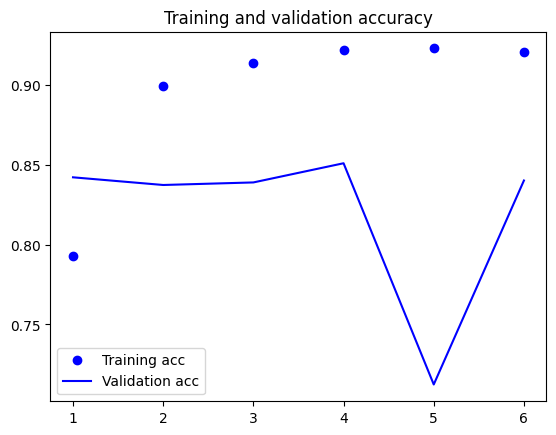

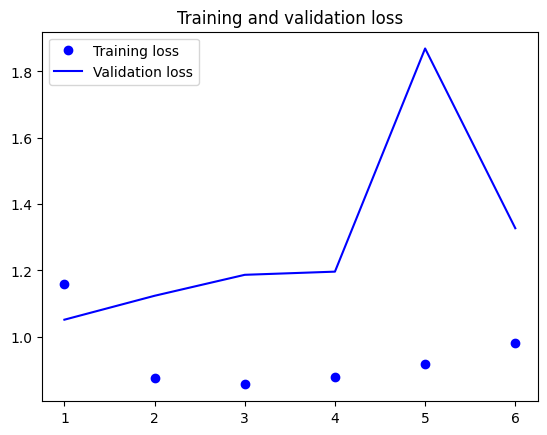

In [99]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc,'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [44]:
#Get features dataset 2/4
train_features_2, train_labels_2 = get_features_and_labels(train_dataset_2)
val_features_2, val_labels_2 = get_features_and_labels(validation_dataset_2)
#test_features_2, test_labels_2 = get_features_and_labels(test_dataset_2)

1/1 [==============================] - 3s 3s/step


In [76]:
history = model.fit(train_features_2, train_labels_2,epochs=40, batch_size=32, validation_data=(val_features_2, val_labels_2),callbacks=[early_stopping, reduce_lr])

Epoch 1/40
312/312 [==============================] - 12s 36ms/step - loss: 0.5760 - accuracy: 0.9979 - val_loss: 0.9506 - val_accuracy: 0.8862 - lr: 1.0000e-05
Epoch 2/40
312/312 [==============================] - 11s 35ms/step - loss: 0.5620 - accuracy: 0.9978 - val_loss: 0.9401 - val_accuracy: 0.8854 - lr: 1.0000e-05
Epoch 3/40
312/312 [==============================] - 12s 39ms/step - loss: 0.5490 - accuracy: 0.9983 - val_loss: 0.9299 - val_accuracy: 0.8846 - lr: 1.0000e-05
Epoch 4/40
312/312 [==============================] - 11s 34ms/step - loss: 0.5382 - accuracy: 0.9985 - val_loss: 0.9223 - val_accuracy: 0.8842 - lr: 1.0000e-05
Epoch 5/40
312/312 [==============================] - 11s 36ms/step - loss: 0.5279 - accuracy: 0.9981 - val_loss: 0.9176 - val_accuracy: 0.8846 - lr: 1.0000e-05
Epoch 6/40
312/312 [==============================] - 11s 36ms/step - loss: 0.5175 - accuracy: 0.9982 - val_loss: 0.9094 - val_accuracy: 0.8830 - lr: 1.0000e-05
Epoch 7/40
312/312 [==============

In [80]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-5),metrics=['accuracy'])

model.save('ModelT_transferLearning_featureExtraction_WithoutDataAumentation_OnlyClassification.keras')

In [83]:
#Get features dataset 3/4
train_features_3, train_labels_3 = get_features_and_labels(train_dataset_3)
val_features_3, val_labels_3 = get_features_and_labels(validation_dataset_3)
#test_features_3, test_labels_3 = get_features_and_labels(test_dataset_3)

1/1 [==============================] - 3s 3s/step


In [98]:
#Treino do modelo guardado com o dataset 2/4
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-5),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

history = model.fit(train_features_3, train_labels_3,epochs=40, batch_size=32, validation_data=(val_features_3, val_labels_3),callbacks=[early_stopping, reduce_lr])

Epoch 1/40
10/10 [==============================] - 4s 186ms/step - loss: 2062.9233 - accuracy: 0.8862 - val_loss: 2164.3459 - val_accuracy: 0.8514 - lr: 1.0000e-05
Epoch 2/40
10/10 [==============================] - 1s 135ms/step - loss: 2062.0842 - accuracy: 0.8844 - val_loss: 2141.2114 - val_accuracy: 0.8542 - lr: 1.0000e-05
Epoch 3/40
10/10 [==============================] - 1s 136ms/step - loss: 2060.4236 - accuracy: 0.8883 - val_loss: 2127.3767 - val_accuracy: 0.8534 - lr: 1.0000e-05
Epoch 4/40
10/10 [==============================] - 1s 142ms/step - loss: 2060.7551 - accuracy: 0.8863 - val_loss: 2118.0486 - val_accuracy: 0.8534 - lr: 1.0000e-05
Epoch 5/40
10/10 [==============================] - 1s 141ms/step - loss: 2062.5388 - accuracy: 0.8839 - val_loss: 2111.2717 - val_accuracy: 0.8538 - lr: 1.0000e-05
Epoch 6/40
10/10 [==============================] - 1s 143ms/step - loss: 2063.7639 - accuracy: 0.8844 - val_loss: 2106.1975 - val_accuracy: 0.8542 - lr: 1.0000e-05
Epoch 7/40

KeyboardInterrupt: 